# ADS Thesis Project - Elastic Net - Goat

**Authors: Marion Späth (2772981)**


This notebook documents the Elastic Net for goat herders.
The datasets have been created in the R file "ML PREPARATIONS.Rmd".

In [1]:
#!pip install shap
#!pip install lightgbm 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import os

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, KFold

from sklearn.linear_model import ElasticNet
from scipy.stats import uniform, loguniform

# with pickle we can save the model, helps with long computation times
import pickle

### Import datasets

In [2]:
pd.set_option('display.max_columns', None) # show all columns in output

# set working directory
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/ML_training')

# load train and test data (previously created in the ElasticNet notebook)
train_goat = pd.read_csv("train_goat_df.csv")
test_goat = pd.read_csv("test_goat_df.csv")
test_goat.head(2)

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_goat,cs_cs_ratio_post_goat,number_minors,educ_child_recoded,educ_child_recodedNUMERIC,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,age_constant_z,number_adults_z,number_minors_z,educ_child_z,educ_adult_z,cs_diff_log,resid_mixed
0,4,4,No,35,Yes,No,Never attended,1,No,0,0,-53.165897,0.0,3,Elementary,7,Student,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.488589,-0.191439,-0.140337,0.922786,-0.474056,3.992052,-0.781516
1,12,4,No,30,No,No,Never attended,1,No,0,0,-115.108932,0.0,3,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,3,Interpersonal Sources,Christian,0,Yes,Lack of Awareness or Understanding,No,No,-0.786820,0.582578,-0.140337,-0.899432,-0.474056,4.754529,-0.050775


# Original Model with Education as a Categorical Variable

### Prepare Datasets for Models

Create dummies for categorical variables and split X and Y values for both test and train data.

In [3]:
# Prepare categorical variables but creating dummies
train_goat = pd.get_dummies(train_goat, drop_first='True')
test_goat = pd.get_dummies(test_goat, drop_first='True')

# Prepare X and Y training sets for models
X_goat = train_goat.copy
X_goat = train_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", 
                              "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_goat = train_goat["resid_mixed"]

X_goat_TEST = test_goat.copy
X_goat_TEST = test_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults",
                                   "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_goat_TEST = test_goat["resid_mixed"]

## Elastic Net

#### Set Up Hyperparameters and Performance Indicators

Prepare cross-validation using randomized grid search for the main hyperparameters and specifying performance metrics to incluede the mean squared error, mean absolute error, and R Squared.
Refit model based on MSE.

In [4]:
# Define Hyperparameters to test
param_dist = {
    'alpha': loguniform(0.0001, 1), # regularisation strength parameter       
    'l1_ratio': uniform(0, 1) # mixture of L1 / L2 penalty
}

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Random Search Setup
elasticnet = RandomizedSearchCV(
    estimator=ElasticNet(max_iter=10000),
    param_distributions=param_dist,
    n_iter=1000,
    cv=cv,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',
    random_state=42,
    n_jobs=-1
)

### Train Model

In [5]:
# Train model
elasticnet.fit(X_goat, Y_goat)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=ElasticNet(max_iter=10000), n_iter=1000, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000012AD416FDD0>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000012AD4233B60>},
                   random_state=42, refit='mse',
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'})

### Get training parameters and RMSE for best training model

In [6]:
# Best Model and Parameters
print("Best params:", elasticnet.best_params_)
print("Best CV score (RMSE):", np.sqrt(-elasticnet.best_score_))

best_model = elasticnet.best_estimator_

Best params: {'alpha': 0.003148911647956862, 'l1_ratio': 0.9507143064099162}
Best CV score (RMSE): 1.3771061119155303


#### Save the model

Model then does not need to be re-run, but can just be imported, saving time.

In [ ]:
# Pickle the model
#with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'elasticnet_m1_goatv1.pickle', 'wb') as to_write:
#    pickle.dump(elasticnet, to_write)

In [8]:
# Read in pickled model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'elasticnet_m1_goatv1.pickle', 'rb') as to_read:
    elasticnet = pickle.load(to_read)

print("Best hyperparameters:\n", elasticnet.best_params_ , "\n")
print("Performance based on best hyperparameter specification MSE:\n", elasticnet.best_score_)

Best hyperparameters:
 {'alpha': 0.003148911647956862, 'l1_ratio': 0.9507143064099162} 

Performance based on best hyperparameter specification MSE:
 -1.8964212434751093


### Make Predicitons on Test Set and Evaluate Performance

In [9]:
best_model = elasticnet.best_estimator_

# 3. Predict on the test set
y_predm1v1 = best_model.predict(X_goat_TEST)

# 4. Evaluate performance
mae = mean_absolute_error(Y_goat_TEST, y_predm1v1)
mse = mean_squared_error(Y_goat_TEST, y_predm1v1)
r2  = r2_score(Y_goat_TEST, y_predm1v1)

print(f"Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):  {np.sqrt(mse):.4f}")
print(f"R-squared (R²):            {r2:.4f}")

Test Set Performance:
Mean Absolute Error (MAE): 1.0414
Root Mean Squared Error (RMSE):  1.3706
R-squared (R²):            0.0088


### Get Built-In Feature Importances

In [10]:
coefficients = elasticnet.best_estimator_.coef_
intercept = elasticnet.best_estimator_.intercept_

coef_df = pd.DataFrame({
    'Feature': X_goat.columns,
    'Coefficient': elasticnet.best_estimator_.coef_
})

# Add column for absolute values and sort
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

coef_df_sorted[["Feature", "Coefficient"]]

,Feature,Coefficient
21,household_description_Not settled: The whole h...,-0.643688
32,trust_vip_Yes,0.213872
23,"main_info_source_recoded_Media, Community-Base...",-0.196588
30,why_not_purchase_recoded_Lack of Awareness or ...,-0.192339
24,main_info_source_recoded_Professional and Orga...,-0.176563
27,household_moved_Yes,-0.151713
17,activity_child_recoded_Not working,-0.126954
31,know_vip_Yes,0.122123
28,why_not_purchase_recoded_Distrust or Negative ...,-0.081832
22,household_description_Partially settled: Some ...,-0.064230


### Plot Actual vs. Predicted Values

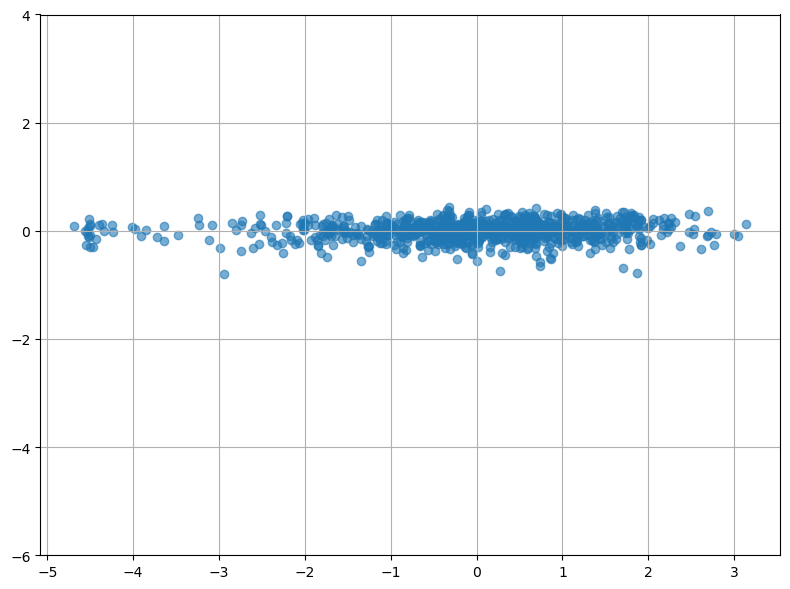

In [11]:
# Residuals = actual - predicted
residuals = Y_goat_TEST - y_predm1v1

plt.figure(figsize=(8, 6))
plt.scatter(Y_goat_TEST, y_predm1v1, alpha=0.6) # Y_goat_TEST

#plt.xlabel("y_predm1v1 Values")
#plt.ylabel("Residuals (Actual - Predicted)")
#plt.title("Residuals vs. y_pred Values")
plt.ylim(-6, 4) 
plt.grid(True)
plt.tight_layout()
plt.show()


## SHAP

### Investigate Shapely Values

In [12]:
# create mapping for proper variable names
labels = {
  "activity_child_recodedWorking": "Child's Activity: Working (Ref: House/Domestic Work)",
  "trust_vip_Yes" : "Trust in VIP (Ref: No)",
  "know_vip_Yes" : "Knows VIP (Ref: No)",
  "educ_recoded_constant_Elementary" : "Adult's Education: Elementary (Ref: Adult Education)",
  "agric_land_Yes" : "Owns Agricultural Land (Ref: No)",
  "activity_child_recoded_Student" : "Child's Activity: Student (Ref: House/Domestic Work)",
  "eng_language_Yes" : "English Language (Ref: No)",
  "why_not_purchase_recoded_Financial, Practical, and Situational Constraints" : "Reason Non-Purchase: Financial, Practical, and Situational Constraints (Ref: Bought Insurance)",
  "activity_child_recoded_Working with Livestock" : "Child's Activity: Livestock Work (Ref: House/Domestic Work)",
  "educ_recoded_constant_Nursery" : "Adult's Education: Nursery  (Ref: Adult Education)",
  "number_minors_z" : "Number of Minors in HH (z)",
  "number_adults_z" : "Number of Adults in HH (z)",
  "owns_phone" : "Owns Phone (Ref: No)",
  "religion_recoded_Traditional/Wakefata" : "Religion: Traditional/Wakefata (Ref: Christian)",
  "religion_recoded_Muslim" : "Religion: Muslim (Ref: Christian)",
  "main_info_source_recoded_Professional and Organizational Sources" : "Info Source: Professional and Organizational Sources (Ref: Interpersonal Sources)",
  "household_moved_Yes" : "Household Moved (Ref: No)",
  "why_not_purchase_recoded_Lack of Awareness or Understanding" : "Reason Non-Purchase: Lack of Awareness / Understanding (Ref: Bought Insurance)",
  "main_info_source_recoded_Media, Community-Based, and Survey Sources" : "Info Source: Media, Community-Based, and Survey Sources  (Ref: Interpersonal Sources)",
  "household_description_Partially settled: Some members of the household are permanently settled and others move around in order to herd their animals" : "Household Partially Settled (Ref: Fully Settled)",
  "household_description_Not settled: The whole household moves around in order to herd the animals" : "Household Not Settled  (Ref: Fully Settled)",
  "age_constant_z" : "Age (z)",
  "educ_child_recoded_Never attended school" : "Child's Education: Never atteneded School (Ref: Elementary)",
  "expend" : "Expend (Ref: No)",
  "afm_language_Yes" : "Afm Language (Ref: No)",
  "amh_language_Yes" : "Amh Language (Ref: No)",
  "educ_recoded_constant_Never attended" : "Adult's Education: Never attended (Ref: Adult Education)",
  "activity_child_recoded_Not working" : "Child's Activity: Not Working (Ref: House/Domestic Work)",
  "educ_child_recoded_Secondary" : "Child's Education: Secondary School (Ref: Elementary)",
  "irrigated_land_bin" : "Irrigated Land (Ref: No)",
  "why_not_purchase_recoded_Distrust or Negative Perception" : "Reason Non-Purchase: Distrust or Negative Perception (Ref: Bought Insurance)",
  "educ_recoded_constant_Secondary and Higher" : "Adult's Education: Secondary and Higher (Ref: Adult Education)",
  "educ_child_recoded_Other" : "Child's Education: Other (Ref: Elementary)",
  "activity_child_recoded_Working" : "Child's Activity: Working (Ref: House/Domestic Work)",
}

In [13]:
# Extract best model
best_model = elasticnet.best_estimator_

# initiate and train explainer
explainer = shap.KernelExplainer(best_model.predict, X_goat)

# apply mapping for variable names
X_goat_renamed = X_goat.rename(columns=labels)

# calculate shapely values for 100 sampled points (for runtime reasons)
X_sample = X_goat.sample(n=100, random_state=0)
shap_values = explainer.shap_values(X_sample)

Using 3523 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

c:\anaconda_custom\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


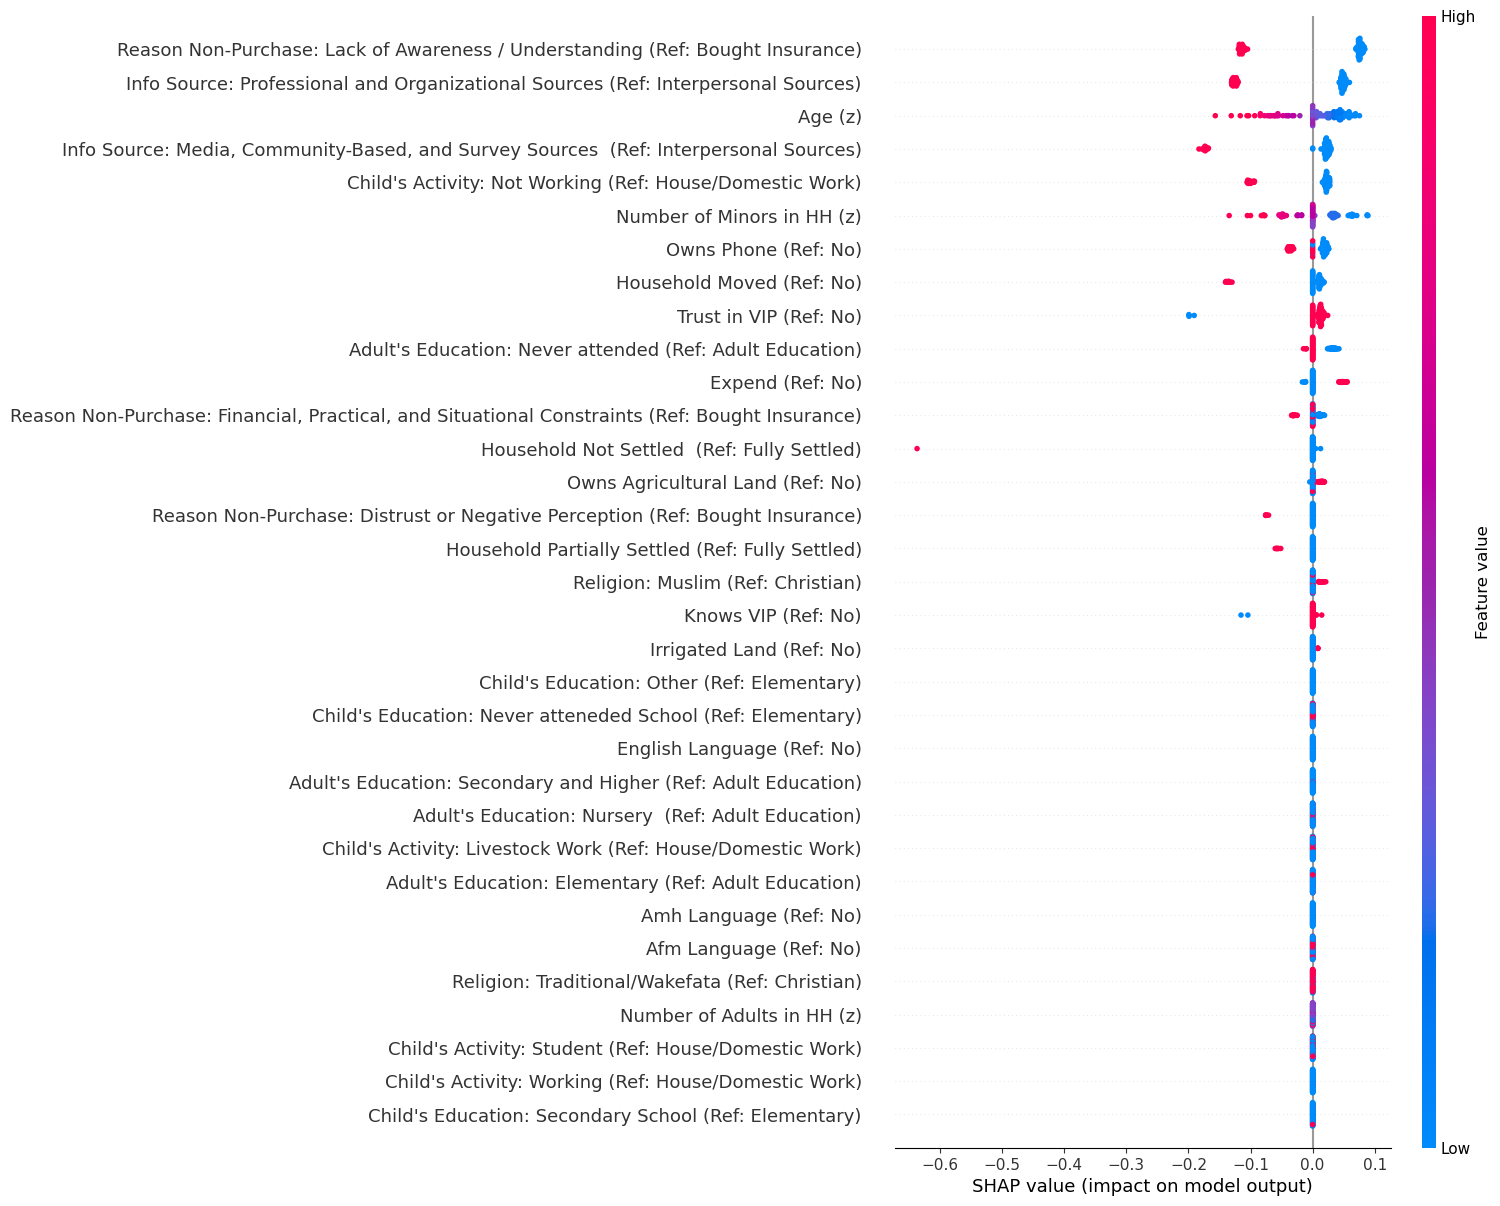

In [14]:
X_sample_renamed = X_sample.rename(columns=labels)

#  Plot SHAP summary for all variables
shap.summary_plot(
    shap_values,
    X_sample_renamed,
    plot_type="dot",
    max_display=100
)

c:\anaconda_custom\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


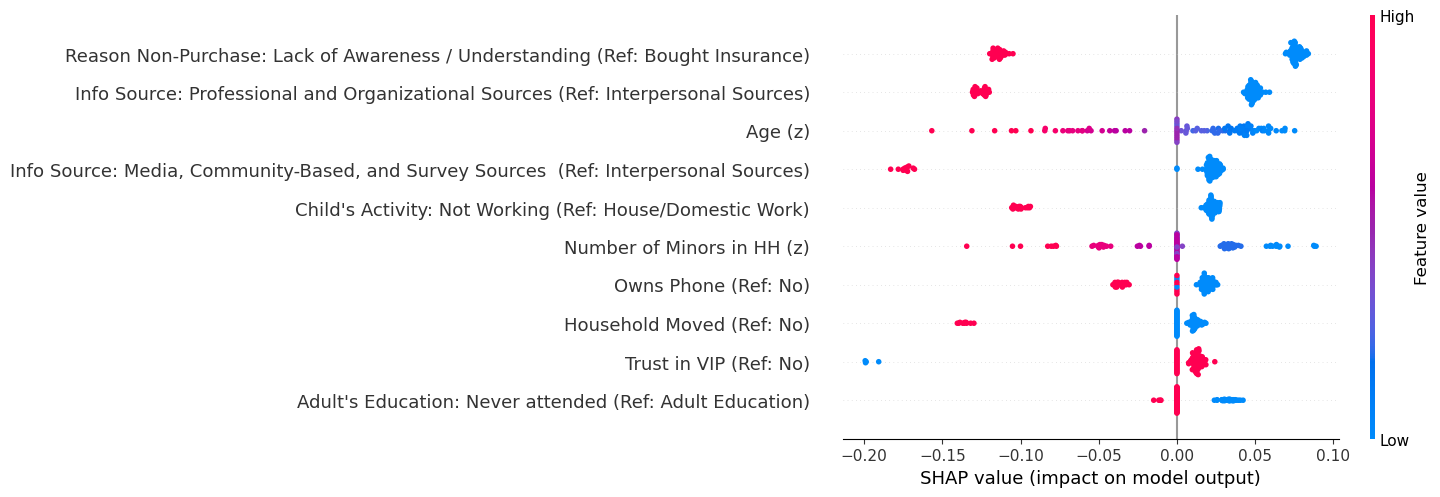

In [15]:
#  Plot SHAP summary for top 10 variables
shap.summary_plot(
    shap_values,
    X_sample_renamed,
    plot_type="dot",
    max_display=10
)

In [16]:
# Compute mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Create DataFrame with feature names
shap_importance = pd.DataFrame({
    "Feature": X_goat_renamed.columns,
    "Mean |SHAP value|": mean_abs_shap
}).sort_values(by="Mean |SHAP value|", ascending=False)  # sort ascending for horizontal bar chart

# Plot top 10 features
top_n = 40
top_features = shap_importance.head(top_n)
top_features

,Feature,Mean |SHAP value|
30,Reason Non-Purchase: Lack of Awareness / Under...,0.089527
24,Info Source: Professional and Organizational S...,0.074380
3,Age (z),0.042534
23,"Info Source: Media, Community-Based, and Surve...",0.042091
17,Child's Activity: Not Working (Ref: House/Dome...,0.037454
5,Number of Minors in HH (z),0.032890
2,Owns Phone (Ref: No),0.021780
27,Household Moved (Ref: No),0.020537
32,Trust in VIP (Ref: No),0.017179
10,Adult's Education: Never attended (Ref: Adult ...,0.014314


## Aggregate Dummy Variables to Original Categorical Feature

The absolute values are summed up to their original, broader variable. Absolute values are used so as to get the variables' strength and avoid positive and negative effects to cancel each other out.

In [17]:
# create mapping of dummies to variable
dummy_groups = {
    "Religion": ["Religion: Muslim (Ref: Christian)", "Religion: Traditional/Wakefata (Ref: Christian)"],
    "Adult's Education": ["Adult's Education: Elementary (Ref: Adult Education)", "Adult's Education: Never attended (Ref: Adult Education)", "Adult's Education: Nursery  (Ref: Adult Education)", "Adult's Education: Secondary and Higher (Ref: Adult Education)"],
    "Child's Education": ["Child's Education: Never atteneded School (Ref: Elementary)", "Child's Education: Other (Ref: Elementary)", "Child's Education: Secondary School (Ref: Elementary)"],
    "Child's Activity": ["Child's Activity: Not Working (Ref: House/Domestic Work)", "Child's Activity: Student (Ref: House/Domestic Work)", "Child's Activity: Working (Ref: House/Domestic Work)", "Child's Activity: Livestock Work (Ref: House/Domestic Work)"],
    "Household Status": ["Household Not Settled  (Ref: Fully Settled)", "Household Partially Settled (Ref: Fully Settled)"],
    "Main Information Source": ["Info Source: Media, Community-Based, and Survey Sources  (Ref: Interpersonal Sources)", "Info Source: Professional and Organizational Sources (Ref: Interpersonal Sources)"],
    "Reason Non-Purchase": ["Reason Non-Purchase: Financial, Practical, and Situational Constraints (Ref: Bought Insurance)", "Reason Non-Purchase: Lack of Awareness / Understanding (Ref: Bought Insurance)", 
                            "Reason Non-Purchase: Distrust or Negative Perception (Ref: Bought Insurance)"],
    "Trust in VIP": ["Trust in VIP (Ref: No)"],
    "Knows VIP": ["Knows VIP (Ref: No)"],
    "Expend" : ["Expend (Ref: No)"],
    "Irrigated Land": ["Irrigated Land (Ref: No)"],
    "Owns Phone": ["Owns Phone (Ref: No)"],
    "Afm Language": ["Afm Language (Ref: No)"],
    "Owns Agricultural Land" : ["Owns Agricultural Land (Ref: No)"],
    "Amh Language": ["Amh Language (Ref: No)"],
    "English Language": ["English Language (Ref: No)"],
    "Household Moved" : ["Household Moved (Ref: No)"]                             
}

# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_sample_renamed.columns)

# Aggregate SHAP values by summing dummy columns
shap_agg = pd.DataFrame(index=shap_df.index)
for group_name, dummy_cols in dummy_groups.items():
    shap_agg[group_name] = shap_df[dummy_cols].abs().sum(axis=1)

# 4. Add remaining non-dummy columns
flattened_dummy_cols = [col for group in dummy_groups.values() for col in group]
non_dummy_cols = [col for col in shap_df.columns if col not in flattened_dummy_cols]
shap_agg[non_dummy_cols] = shap_df[non_dummy_cols]

In [ ]:
# Note: colour scaling does still not apply to the categorical variable. Thus, this graph could be used for the overall inspection of effects but not for deeper analyses and interpretation.
#shap.summary_plot(shap_agg.values, features=shap_agg, feature_names=shap_agg.columns)

### Aggregate SHAP values to get Overall Feature Importances

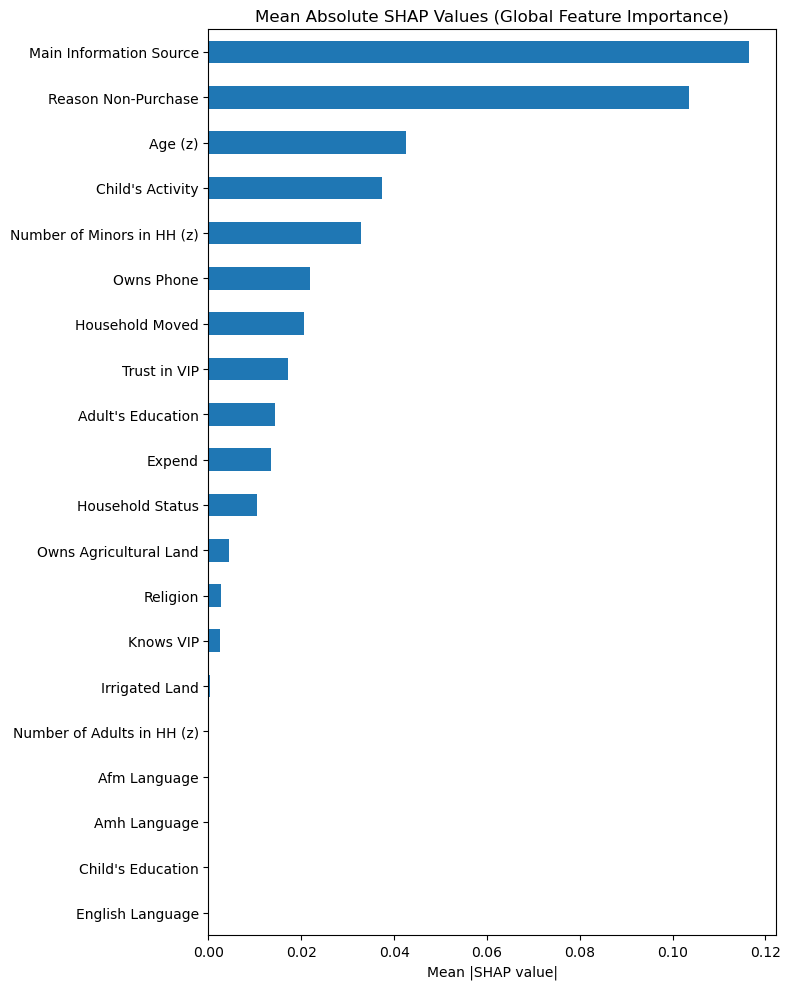

In [18]:
# Create Mean SHAP values across datapoints, effectively: Overall Feature Importancess
feature_importance = pd.Series(
    np.abs(shap_agg).mean(axis=0),
    index=shap_agg.columns
).sort_values(ascending=True)

# Plot
feature_importance.plot(kind='barh', figsize=(8, 10))
plt.title('Mean Absolute SHAP Values (Global Feature Importance)')
plt.xlabel('Mean |SHAP value|')
plt.tight_layout()
plt.show()

In [19]:
# turn into dataframe, add column names and save
feature_importance = feature_importance.reset_index()
feature_importance.columns = ['feature', 'importance']

feature_importance
feature_importance.to_csv("feature_importance_elastic_net_goat.csv", header=True, index=False)

# Refit using Education Variables as Numeric Variables

Goal: By (slightly) reducing the number of categorical variables, and increasing the number of numeric variables, the R2 might be increased. 

In [2]:
pd.set_option('display.max_columns', None) # show all columns in output

# set working directory
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/ML_training')

# load train and test data (previously created in the ElasticNet notebook)
train_goat = pd.read_csv("train_goat_df.csv")
test_goat = pd.read_csv("test_goat_df.csv")

# Prepare X and Y training sets for models
X_goat = train_goat.copy
X_goat = train_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", "educ_recoded_constant", "educ_child_recoded",
                              "number_minors", "age_constant", "cs_diff_log"], axis=1)

Y_goat = train_goat["resid_mixed"]

X_goat_TEST = test_goat.copy
X_goat_TEST = test_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", "educ_recoded_constant", "educ_child_recoded",
                              "number_minors", "age_constant", "cs_diff_log"], axis=1)

Y_goat_TEST = test_goat["resid_mixed"]

# Prepare categorical variables but creating dummies
X_goat = pd.get_dummies(X_goat, drop_first='True')
X_goat_TEST = pd.get_dummies(X_goat_TEST, drop_first='True')
X_goat_TEST.columns

Index(['expend', 'irrigated_land_bin', 'owns_phone', 'age_constant_z',
       'number_adults_z', 'number_minors_z', 'educ_child_z', 'educ_adult_z',
       'afm_language_Yes', 'agric_land_Yes', 'amh_language_Yes',
       'eng_language_Yes', 'activity_child_recoded_Not working',
       'activity_child_recoded_Student', 'activity_child_recoded_Working',
       'activity_child_recoded_Working with Livestock',
       'household_description_Not settled: The whole household moves around in order to herd the animals',
       'household_description_Partially settled: Some members of the household are permanently settled and others move around in order to herd their animals',
       'main_info_source_recoded_Media, Community-Based, and Survey Sources',
       'main_info_source_recoded_Professional and Organizational Sources',
       'religion_recoded_Muslim', 'religion_recoded_Traditional/Wakefata',
       'household_moved_Yes',
       'why_not_purchase_recoded_Distrust or Negative Perception',


In [4]:
# Define Hyperparameters to test
param_dist = {
    'alpha': loguniform(0.0001, 1), # regularisation strength parameter       
    'l1_ratio': uniform(0, 1) # mixture of L1 / L2 penalty
}

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Random Search Setup
elasticnet = RandomizedSearchCV(
    estimator=ElasticNet(max_iter=10000),
    param_distributions=param_dist,
    n_iter=1000,
    cv=cv,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',
    random_state=42,
    n_jobs=-1
)

# Train model
elasticnet.fit(X_goat, Y_goat)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=ElasticNet(max_iter=10000), n_iter=1000, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C58824F4D0>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C58FD216A0>},
                   random_state=42, refit='mse',
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'})

In [ ]:
# Pickle the model
#with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'elasticnet_m2_goatv1.pickle', 'wb') as to_write:
#    pickle.dump(elasticnet, to_write)

In [6]:
# Read in pickled model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'elasticnet_m2_goatv1.pickle', 'rb') as to_read:
    elasticnet = pickle.load(to_read)

print("Best hyperparameters:\n", elasticnet.best_params_ , "\n")
print("Performance based on best hyperparameter specification MSE:\n", elasticnet.best_score_)

Best hyperparameters:
 {'alpha': 0.002423253820683752, 'l1_ratio': 0.9756102008599149} 

Performance based on best hyperparameter specification MSE:
 -1.8952941070630427


### Make Predicitons on Test Set and Evaluate Performance

In [7]:
best_model = elasticnet.best_estimator_

# 3. Predict on the test set
y_predm1v1 = best_model.predict(X_goat_TEST)

# 4. Evaluate performance
mae = mean_absolute_error(Y_goat_TEST, y_predm1v1)
mse = mean_squared_error(Y_goat_TEST, y_predm1v1)
r2  = r2_score(Y_goat_TEST, y_predm1v1)

print(f"Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE):  {np.sqrt(mse):.4f}")
print(f"R-squared (R²):            {r2:.4f}")

Test Set Performance:
Mean Absolute Error (MAE): 1.0414
Root Mean Squared Error (RMSE):  1.3706
R-squared (R²):            0.0087
